# Sieci neuronowe	- Wstęp

Na dzisiejszym wykładzie poznaliśmy jak "myśli" sztuczna inteligencja. Teraz twoim zadaniem będzie napisać swoją własną sieć neuronową (sic!) i zobaczyć jak sobie radzi z przykładowymi problemami.

W tym notebooku znajdują się dwa zadania i twoim zadaniem jest zdobyć jak największy możliwy wynik!

Oczywiście, zanim przejdziemy do tych zadań wypada wyjaśnić niektóre pojęcia :DD



## MLP, warstwy, wymiary, funkcje nieliniowe
<img src="https://miro.medium.com/v2/0*DKavhvcUrT_od6ON" alt="MLP_drawing" width="600"/>


### Co to jest MLP?
**MLP (Multilayer Perceptron)** to sieć złożona z *kilku warstw liniowych*
przeplatanych *nieliniowościami* (funkcjami, które nie są liniowe).

Oczywiście brzmi to mega mądrze, ale co to tak naprawdę znaczy?

Możemy myśleć o warstwach jako klockach (tak naprawdę to takich trapezach) i by połączenie między nimi miało sens, to muszą się zgadzać wymiarem (wysokością). Oczywiście jak budujemy coś z klocków, to warto połączyć je klejem/spoiwem i w naszym przypadku będą to po prostu funkcje, które pozwolą modelowi lepiej się czegoś nauczyć.

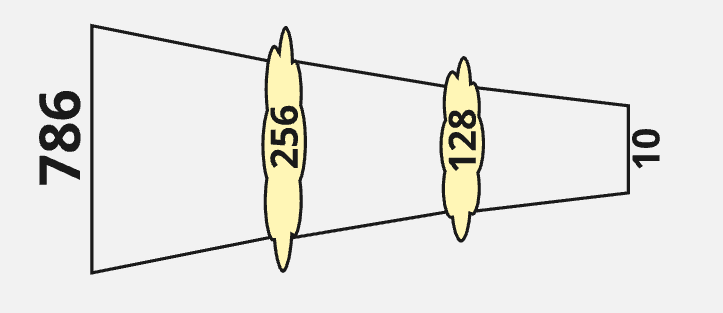

### Przykładowe funkcje (spoiwa) które warto znać:

- **Tanh** - kolega Tangensa, Zwraca liczby od **-1 do 1**. Średnio daje wartości blisko **0**, więc kolejne warstwy mają „ładny start”.
<img src="https://miro.medium.com/v2/1*WeuJzmlt3iNVWsUsvf24Eg.png" alt="Tanh" width="600"/>

- **ReLU** - kolega funkcji identycznościowej (y = x), dla `x > 0` zwraca **x**, dla `x ≤ 0` zwraca **0**.
**Szybka i prosta**, dobrze działa w **głębokich sieciach**. Często daje **więcej sygnału** (łatwiej się uczy) niż tanh/sigmoid.

<img src="https://miro.medium.com/v2/resize:fit:357/1*oePAhrm74RNnNEolprmTaQ.png" alt="Relu" width="600"/>

- **Sigmoid** - Zwraca liczby od **0 do 1**. Idealna na **wyjściu** przy **klasyfikacji binarnej** (można czytać jak „prawdopodobieństwo”). W środku sieci bywa wolniejsza w uczeniu niż ReLU.

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20250131185746649092/Sigmoid-Activation-Function.png" alt="Sigmoid" width="600"/>

## Uczenie się sieci, jak to działa?

Chcemy, żeby model **sam nauczył się** zamieniać wejście (np. obrazek) na właściwą odpowiedź (np. „to są buty”).  
Robimy to metodą małych kroków:

- Najpierw **model zgaduje** (robi predykcję).
- Porównujemy zgadywankę z prawdą i liczymy **błąd (loss)** – to nasz „termometr jakości”.
- Pytamy: **w którą stronę** przesunąć wagi, żeby **błąd był mniejszy**? (to rola **gradientu**).
- Robimy **mały krok** w tę stronę (wielkość kroku to **learning rate**).
- Powtarzamy to dla **paczek danych** (**batch_size**) i wielu przebiegów (**epok**).

W efekcie błąd powinien **spadać**, a trafność rosnąć.  
Cała magia to powtarzanie prostego schematu: *zgadnij → policz błąd → popraw się o kawałek*.


### Przykładowe uczenie się
<img src="https://media.geeksforgeeks.org/wp-content/uploads/20240217152156/Frame-13.png" alt="MLP_drawing" width="600"/>

### Jakie znaczenie ma **learning rate** oraz **batch size**

**Learning rate (LR)** = długość kroku przy schodzeniu z góry.
- za duży → skaczesz i wypadasz z doliny;
- za mały → idziesz jak ślimak.

Start: 1e-3 (Adam) lub 1e-2 (SGD) i patrz na wykres loss/accuracy.

**Batch size (BS)** = ile przykładów naraz liczymy gradient.
- Mały (32–64) → bardziej „poszarpane” kroki, mniejsze zużycie pamięci.
- Duży (128–256+) → stabilniejsze kroki, większa pamięć; czasem trochę gorsza generalizacja.

## 0. Przygotowanie środowiska

Poniżej importujemy biblioteki, ustawiamy losowość i sprawdzamy, czy jest dostępny GPU. Jeśli nie, wszystko zadziała na CPU (tylko wolniej).

In [1]:
import random

import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

print("Seed ustawiony na 0")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


Seed ustawiony na 0


device(type='cpu')

---
## 1. Zadanie „Łączenie klocków” — MNIST + `nn.Sequential`

Zaraz dowiemy się jak stworzyć prostą sieć neuronową z użyciem `nn.Sequential`, nauczymy ją na zbiorze MNIST i poeksperymentujemy z **batch size**, **learning rate**, oraz architekturą (dodawanie/usuwanie „klocków” — warstw).

Twoim celem jest zdobyć jak największą dokładność w mniej niż **3 minuty**!

Najlepszy wynik zdobędzie koronę ML'a!

### 1.1. Dane: MNIST
MNIST to zbiór **obrazków 28×28 pikseli** z cyframi 0–9 napisanymi przez ludzi. Każdy przykład ma etykietę (liczbę), a naszym zadaniem jest rozpoznanie, **która to cyfra**.

**Wejście (input):** obraz 28×28, który spłaszczamy do wektora długości 784.  
**Wyjście (output):** 10 liczb (logity) - po odpowiednim przekształceniu będzie to reprezentować prawdopodobieństwo, że na obrazku jest dana cyfra.


In [2]:
# Transformacje: tensory + normalizacja (typowa dla MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

len(train_ds), len(test_ds)

(60000, 10000)

Krótki pokaz jak wyglądają dane

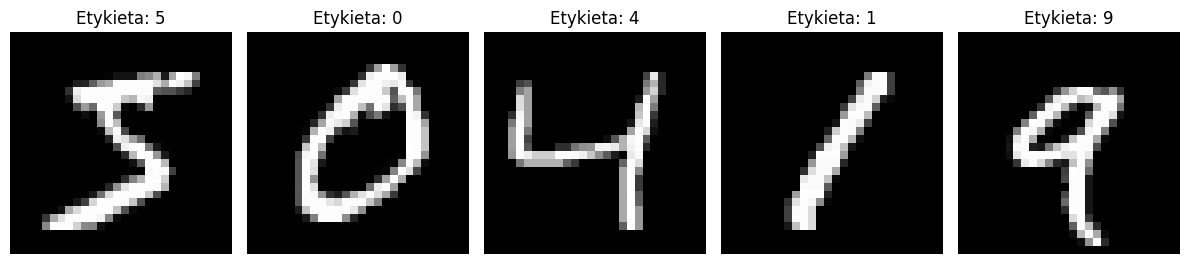

In [3]:
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i, ax in enumerate(axes):
    img, label = train_ds[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Etykieta: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

### 1.2. Funkcja do załadowania danych

To tutaj właśnie używamy naszego batch_size'u, który będzie odpowiadał ile danych na raz będziemy rozpatrywać


In [4]:
def load_data(data_ds, batch_size=128, shuffle=True):
  data_dl = DataLoader(data_ds, batch_size=batch_size, shuffle=shuffle)
  return data_dl


### 1.3. Funkcja straty i optymalizator

Zgodnie z tym, co pisaliśmy już, to tutaj zmieniamy funkcję, która będzie odpowiedzialna za "mówienie" modelowi czy idzie w dobrą stronę, czy nie (często nazywamy to `criterion`). Natomiast strażnik, który odpowiada za to, gdzie i jak poruszać się po "górze" to `optimizer` i on będzie korzystał ze zdefiniowanego przez nas learning_rate'u.


In [5]:
def get_criterion_and_optimizer(model, learning_rate=0.01):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  # możesz zmienić na np. Adam
  return criterion, optimizer


### 1.4. Pętla treningowa + ewaluacja

Ta funkcja uruchamia **pełen cykl uczenia**: wiele **epok**, a w każdej epoce — przejście po wszystkich **paczkach** (batch-ach) danych. Mierzymy **błąd (loss)** i **trafność (accuracy)**, a na końcu dostajemy historię do wykresów.

---

### Szybki plan
- Startujemy stoperem (`perf_counter`) i tworzymy **notatnik wyników** (`history`).
- Dla każdej **epoki**:
  1. Przełączamy model w tryb **treningowy** (`model.train()`).
  2. Idziemy po **paczkach** danych: przód → loss → wstecz → aktualizacja.
  3. Liczymy **średnią stratę** dla epoki.
  4. Sprawdzamy **accuracy** na zbiorze testowym.
  5. Zapisujemy wyniki i drukujemy podsumowanie epoki.
- Na koniec drukujemy **czas** i zwracamy `history`.
---

### Ten najważniejszy fragment (pętla po batchach)

```python
for x, y in train_dl:
    x, y = x.to(device), y.to(device)        # 1) przerzut na GPU/CPU, na którym jest model
    optimizer.zero_grad()                    # 2) czyścimy stare gradienty
    logits = model(x)                        # 3) PRZÓD: predykcja modelu
    loss = criterion(logits, y)              # 4) LICZYMY BŁĄD (loss)
    loss.backward()                          # 5) WSTECZ: gradienty dla wag
    optimizer.step()                         # 6) AKTUALIZACJA wag (krok opt.)
    running_loss += loss.item() * y.size(0)  # 7) sumujemy błąd dla epoki
```

**Co tu się dzieje „po ludzku”?**  
Model robi **zgadywankę**, porównujemy ją z prawdą (to właśnie **loss**), a potem „pytamy” model, w którą stronę **poprawić wagi**, żeby następnym razem pomylił się **mniej** (to rola **gradientów**). Na końcu robimy **mały krok** poprawy (jego wielkość ustala **learning rate**).

Po wyjściu z tej pętli liczymy **średnią stratę** w epoce:
```python
train_loss = running_loss / len(train_dl.dataset)
```

---

### Sprawdzanie postępów (accuracy)
Po każdej epoce liczymy trafność na teście:
```python
test_acc = accuracy(model, test_dl)
```
- `model.eval()` (wewnątrz `accuracy`) → tryb **ewaluacji** (bez dropoutów itp.).
- `torch.no_grad()` → **szybciej** i **oszczędniej** (bez liczenia gradientów).
- `argmax(dim=1)` → wybór **najpewniejszej klasy**; zliczamy trafienia / ogółem.

Wyniki dorzucamy do `history` i drukujemy np.:
```
Epoch 03 | loss=0.4215 | test_acc=88.12%
```

---

### Na co masz wpływ (3 dźwignie)
- **`epochs`** – ile razy przechodzimy cały zbiór; więcej epok → zwykle lepiej (do momentu nasycenia).
- **`learning_rate`** – **długość kroku** poprawy wag: za duży = skacze i gubi dolinę, za mały = idzie jak ślimak.
- **`batch_size`** – **ile przykładów naraz** liczy gradient: mały = „poszarpane” kroki i mniejsze zużycie pamięci, duży = stabilniej, ale więcej RAM/GPU.



In [6]:
from time import perf_counter
from tqdm import tqdm

def accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total


def train(model, optimizer, criterion, train_dl, test_dl, epochs=100, ):

  history = {'epoch': [], 'train_loss': [], 'test_acc': []}

  start = perf_counter()
  for epoch in tqdm(range(1, epochs+1)):
      model.train()
      running_loss = 0.0
      for x, y in train_dl:
          x, y = x.to(device), y.to(device)
          optimizer.zero_grad()
          logits = model(x)
          loss = criterion(logits, y)
          loss.backward()
          optimizer.step()
          running_loss += loss.item() * y.size(0)

      train_loss = running_loss / len(train_dl.dataset)
      test_acc = accuracy(model, test_dl)
      history['epoch'].append(epoch)
      history['train_loss'].append(train_loss)
      history['test_acc'].append(test_acc)
      print(f"Epoch {epoch:02d} | loss={train_loss:.4f} | test_acc={test_acc*100:.2f}%")

  elapsed = perf_counter() - start
  print(f"\nCzas trenowania: {elapsed:.1f}s na {device}.")
  assert elapsed < 180, "Przekroczono czas!"
  return history

### 1.5. Wykres: strata vs. epoka i dokładność vs. epoka
Zobacz, czy Twoje zmiany pomagają.


In [7]:
# Pamiętaj: jeden wykres na figurę (bez subplots), bez narzucania kolorów.
import matplotlib.pyplot as plt


def plot_history(history):
  plt.figure()
  plt.plot(history['epoch'], history['train_loss'], marker='o')
  plt.title('Strata treningowa vs. epoka')
  plt.xlabel('Epoka')
  plt.ylabel('Strata')
  plt.grid(True)
  plt.show()

  plt.figure()
  plt.plot(history['epoch'], [a*100 for a in history['test_acc']], marker='o')
  plt.title('Dokładność testowa vs. epoka')
  plt.xlabel('Epoka')
  plt.ylabel('Accuracy [%]')
  plt.grid(True)
  plt.show()

### 1.6. Model jako „klocki” w `nn.Sequential`

Poniżej definiujemy prostą sieć MLP (perceptron wielowarstwowy). Każdy „klocek” to warstwa, np. `nn.Linear` lub funkcja aktywacji np. `nn.ReLU()`.

> **Jak ulepszyć:** dodaj/usuń **klocki** (np. kolejny `nn.Linear` + `nn.ReLU`) i zobacz, czy model działa lepiej, czy gorzej. Jeśli chcesz poszukać możliwie inne funkcje to odwiedź [dokumentację](https://docs.pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).

> **Jak ulepszyć:** Pozmieniaj hiperparametry i zobacz różnicę!

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=10, bias=True)
)


 10%|█████▉                                                     | 1/10 [00:08<01:13,  8.19s/it]

Epoch 01 | loss=0.8141 | test_acc=89.29%


 20%|███████████▊                                               | 2/10 [00:16<01:07,  8.50s/it]

Epoch 02 | loss=0.3719 | test_acc=91.01%


 30%|█████████████████▋                                         | 3/10 [00:25<01:00,  8.59s/it]

Epoch 03 | loss=0.3150 | test_acc=91.91%


 40%|███████████████████████▌                                   | 4/10 [00:34<00:52,  8.69s/it]

Epoch 04 | loss=0.2839 | test_acc=92.40%


 50%|█████████████████████████████▌                             | 5/10 [00:43<00:43,  8.79s/it]

Epoch 05 | loss=0.2612 | test_acc=93.02%


 60%|███████████████████████████████████▍                       | 6/10 [00:52<00:35,  8.83s/it]

Epoch 06 | loss=0.2421 | test_acc=93.49%


 70%|█████████████████████████████████████████▎                 | 7/10 [01:00<00:25,  8.63s/it]

Epoch 07 | loss=0.2258 | test_acc=93.84%


 80%|███████████████████████████████████████████████▏           | 8/10 [01:08<00:17,  8.57s/it]

Epoch 08 | loss=0.2120 | test_acc=94.04%


 90%|█████████████████████████████████████████████████████      | 9/10 [01:17<00:08,  8.46s/it]

Epoch 09 | loss=0.1997 | test_acc=94.31%


100%|██████████████████████████████████████████████████████████| 10/10 [01:25<00:00,  8.56s/it]

Epoch 10 | loss=0.1891 | test_acc=94.61%

Czas trenowania: 85.6s na cpu.


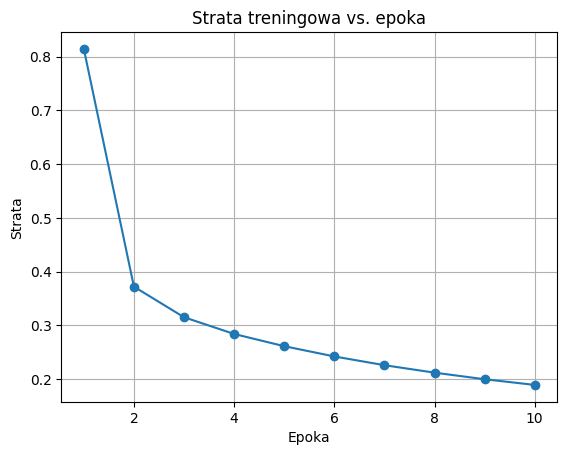

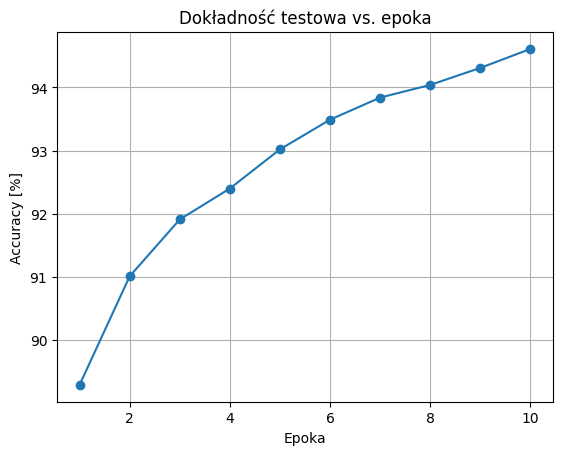

In [8]:
# Hiperparametry
batch_size = 128      # spróbuj np. 32, 64, 128, 256
learning_rate = 1e-2  # spróbuj np. 1e-1, 1e-2, 5e-3, 1e-3
epochs = 10           # Z reguły im większe, tym lepsze, ale pamiętaj, że masz tylko 3 minuty na obliczenia!


# Model
## Wejście: 784 -> 100 -> 10 (klasy)
input_size = 28*28
output_size = 10

model = nn.Sequential(
    nn.Flatten(),           # zamieniamy zdjęcie 28x28 -> 784
    nn.Linear(input_size, 100),
    nn.ReLU(),
    nn.Linear(100, output_size)      # logity dla 10 klas
).to(device)
print(model)

train_dl = load_data(train_ds, batch_size=batch_size, shuffle=True)
test_dl = load_data(test_ds, batch_size=batch_size, shuffle=False)

criterion, optimizer = get_criterion_and_optimizer(model, learning_rate=learning_rate)

history = train(model, optimizer, criterion, train_dl, test_dl, epochs)

plot_history(history)


---
## 2. Zadanie „Co robi Linear?” — własny bloczek + Fashion-MNIST

Wbudowana warstwa `nn.Linear` realizuje przekształcenie:  

$\textbf{y} = \textbf{x} \cdot W^T + \textbf{b}$

gdzie:
- **x** — wejście (batch $\times$ in_features),
- **W** — wagi (out_features $\times$ in_features),
- **b** — bias (out_features).

W tym zadaniu napiszesz **własny** moduł `MyLinear` z parametrami `W` i `b` oraz **metodą `forward`**.
PyTorch automatycznie policzy pochodne (backprop) dzięki autograd, jeśli w `forward` użyjesz operacji na tensorach z `nn.Parameter`.

Ponadto tutaj również jest konkurs na to, kto zrobi najlepszy model, którego czas działania będzie wynosić **3 minuty**!

### 2.1. Dane: Fashion-MNIST
To też obrazy 28×28, ale przedstawiają elementy garderoby (T-shirt, buty itd.). Dzięki temu zobaczysz inny zestaw danych przy identycznej architekturze.


In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

fmnist_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
fmnist_test  = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

len(fmnist_train), len(fmnist_test)

100%|█████████████████████████████████████████████████████| 26.4M/26.4M [00:00<00:00, 51.7MB/s]
100%|█████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 1.07MB/s]
100%|█████████████████████████████████████████████████████| 4.42M/4.42M [00:00<00:00, 18.9MB/s]
100%|█████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 22.3MB/s]


(60000, 10000)

Krótki pokaz jak wyglądają dane

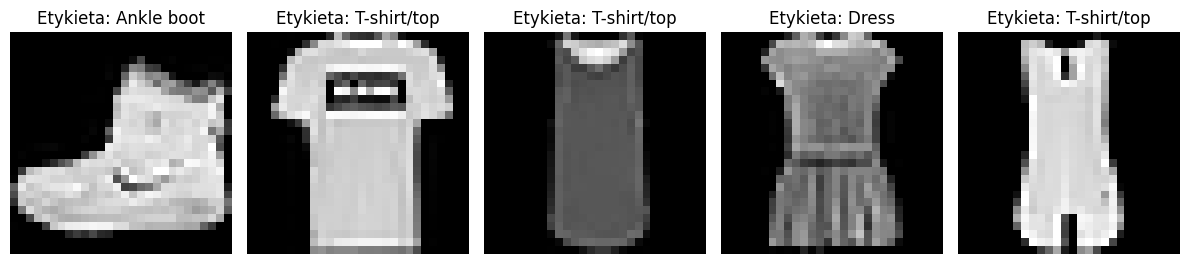

In [10]:
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
class_names = fmnist_train.classes
for i, ax in enumerate(axes):
    img, label = fmnist_train[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Etykieta: {class_names[label]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

### 2.2. Implementacja własnej warstwy `MyLinear`

> **Twoje zadanie:**
- stwórz W (wagi), b (bias) odpowiednich rozmiarów! (.uniform_ pozwala nam losować już odpowiednie wartości w środku więc to musi zostać!)
- uzupełnij `forward`, będzie to przemnożenie `x` z macierzą `W` (możliwie transponowaną, czemu?) i dodanie do wyniku wektora `b`. Dodatkowe informacje które mogą się przydać ([dokumentacja](https://docs.pytorch.org/docs/stable/generated/torch.matmul.html), [wikipedia odnośnie mnożenia macierzy](https://pl.wikipedia.org/wiki/Mnożenie_macierzy), [matemaks odnośnie mnożenia macierzy](https://www.matemaks.pl/mnozenie-macierzy.html))


In [11]:
class MyLinear(nn.Module):
    def __init__(self, rozmiar_wejscia, rozmiar_wyjscia):
        super().__init__()
        limit = (1 / rozmiar_wejscia) ** 0.5
        self.W = nn.Parameter(torch.empty(<...>, <...>).uniform_(-limit, limit))
        self.b = nn.Parameter(torch.empty(<...>).uniform_(-limit, limit))

    def forward(self, x):
        y = ...
        return y

# Krótki test zgodności z nn.Linear
torch.manual_seed(0)
lin_ref = nn.Linear(4, 3, bias=True)
my_lin  = MyLinear(4, 3)
# Skopiujmy parametry, żeby porównać wyjście 1:1
with torch.no_grad():
    my_lin.W.copy_(lin_ref.weight)
    my_lin.b.copy_(lin_ref.bias)

x = torch.randn(2, 4)
out_ref = lin_ref(x)
out_my  = my_lin(x)
print(out_ref, out_my)
print('Max absol. różnica:', (out_ref - out_my).abs().max().item())

tensor([[-1.0656,  0.4617, -0.3161],
        [-0.4111, -0.6190, -0.2267]], grad_fn=<AddmmBackward0>) tensor([[-1.0656,  0.4617, -0.3161],
        [-0.4111, -0.6190, -0.2267]], grad_fn=<AddBackward0>)
Max absol. różnica: 0.0


### 2.3. Sieć z własnym `MyLinear`

Użyjemy tej samej idei: spłaszcz obraz 28×28 → parę warstw liniowych z aktywacjami.
Możesz mieszać `MyLinear` z wbudowanym `nn.Linear`.

Zauważmy, że tak naprawdę resztę możemy przepisać tak, jak mieliśmy wyżej (tylko ze zmianą danych i modelu :D)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): MyLinear()
  (2): ReLU()
  (3): MyLinear()
)


 10%|█████▉                                                     | 1/10 [00:08<01:13,  8.18s/it]

Epoch 01 | loss=0.8314 | test_acc=79.05%


 20%|███████████▊                                               | 2/10 [00:16<01:05,  8.20s/it]

Epoch 02 | loss=0.5373 | test_acc=80.88%


 30%|█████████████████▋                                         | 3/10 [00:24<00:57,  8.16s/it]

Epoch 03 | loss=0.4837 | test_acc=82.48%


 40%|███████████████████████▌                                   | 4/10 [00:32<00:49,  8.28s/it]

Epoch 04 | loss=0.4566 | test_acc=82.84%


 50%|█████████████████████████████▌                             | 5/10 [00:42<00:43,  8.62s/it]

Epoch 05 | loss=0.4375 | test_acc=82.69%


 60%|███████████████████████████████████▍                       | 6/10 [00:50<00:34,  8.52s/it]

Epoch 06 | loss=0.4228 | test_acc=83.66%


 70%|█████████████████████████████████████████▎                 | 7/10 [00:59<00:25,  8.61s/it]

Epoch 07 | loss=0.4110 | test_acc=84.05%


 80%|███████████████████████████████████████████████▏           | 8/10 [01:07<00:17,  8.56s/it]

Epoch 08 | loss=0.4008 | test_acc=83.70%


 90%|█████████████████████████████████████████████████████      | 9/10 [01:16<00:08,  8.52s/it]

Epoch 09 | loss=0.3914 | test_acc=84.65%


100%|██████████████████████████████████████████████████████████| 10/10 [01:24<00:00,  8.49s/it]

Epoch 10 | loss=0.3831 | test_acc=85.17%

Czas trenowania: 84.9s na cpu.


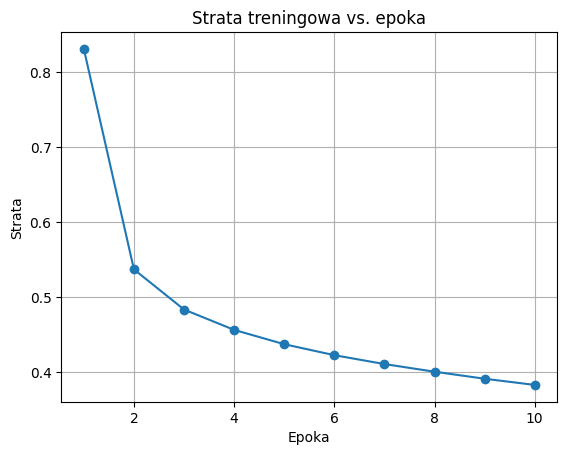

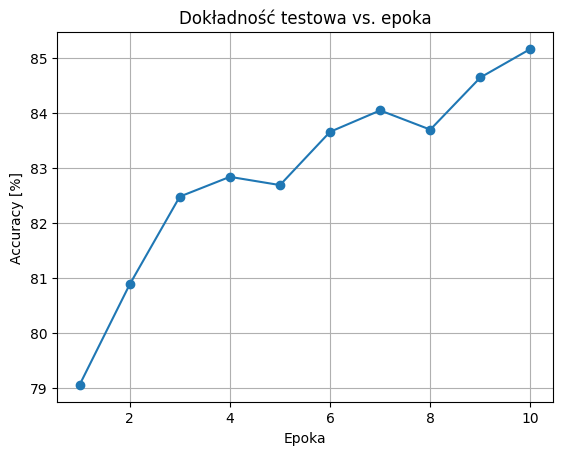

In [12]:
# Hiperparametry
batch_size = 128
learning_rate = 1e-2
epochs = 10

# Model
input_size = 28*28
output_size = 10

f_model = nn.Sequential(
    nn.Flatten(),
    MyLinear(input_size, 128),
    nn.ReLU(),
    MyLinear(128,output_size)
).to(device)
print(f_model)

train_dl = load_data(fmnist_train, batch_size=batch_size, shuffle=True)
test_dl = load_data(fmnist_test, batch_size=batch_size, shuffle=False)

criterion, optimizer = get_criterion_and_optimizer(f_model, learning_rate=learning_rate)

history = train(f_model, optimizer, criterion, train_dl, test_dl, epochs)

plot_history(history)


---
# 3. Słowniczek pojęć (dla szybkiej powtórki)

- **Batch size** — ile przykładów przetwarzamy na raz. Wpływa na zużycie pamięci i stabilność kroku.
- **Learning rate (LR)** — wielkość kroku optymalizatora. Zbyt duży = rozbieżność; zbyt mały = wolne uczenie.
- **Wejście/wyjście (input/output)** — kształt danych do modelu (np. 28×28 → 784) i liczba klas (np. 10).
- **`nn.Sequential`** — szybki sposób „układania klocków” sieci: warstwa po warstwie.
- **`nn.Linear`** — przekształcenie liniowe: `y = x @ W^T + b`.
- **Funkcja aktywacji** — nieliniowość (np. `ReLU`) umożliwiająca modelowi uczyć się złożonych zależności.
- **Loss (strata)** — miara błędu. Dążymy do minimalizacji.
- **Optymalizator** — algorytm aktualizacji wag (np. SGD, Adam).
- **Epoka** — jedno przejście przez cały zbiór treningowy.

> Porada: rób **małe, kontrolowane eksperymenty**. Zmieniaj **jedną rzecz naraz** i notuj rezultat.
